
Adaptive filtering techniques are a crucial component of image processing, used to enhance or modify images by adjusting their pixel values based on the surrounding pixels. These techniques are essential in various applications, including noise reduction, edge detection, and image enhancement. Here's a list of some adaptive filtering techniques and methods used in image processing:

- **Adaptive Median Filter**: This filter adjusts its size based on local characteristics of the image, helping to preserve edges while reducing noise.
- **Adaptive Wiener Filter**: Utilizes statistical characteristics of the image to adapt the filter to varying noise conditions across the image.
- **Anisotropic Diffusion (Perona-Malik Filter)**: This non-linear filtering method aims to reduce image noise without removing significant parts of the image content, such as edges, lines, or other details that are important for interpretation.
- **Bilateral Filter**: An edge-preserving and noise-reducing smoothing filter that considers both spatial proximity and pixel value differences.
- **Guided Filter**: An edge-aware filter, which is used for edge-preserving smoothing and can be considered as an alternative to the bilateral filter.
- **Least Mean Squares (LMS) Filter**: A type of adaptive filter that adjusts its coefficients to minimize the mean square error between its output and a desired output.
- **Recursive Least Squares (RLS) Filter**: Offers faster convergence than LMS by using a recursive approach to update the filter coefficients.
- **Kalman Filter**: Used in scenarios where noise and other inaccuracies are present, especially effective in time-varying images or sequences.
- **Non-Local Means Filter**: A filtering technique that averages the value of each pixel based on the similarity of small patches around the pixel, rather than just geometric closeness.
- **Savitzky-Golay Filter**: Smoothes and differentiates data by fitting successive subsets of adjacent data points with a low-degree polynomial.
- **Sigma Filter**: Also known as the Sigma-Delta filter, it is used for noise filtering while preserving sharp edges by considering the statistical variance within a local neighborhood.
- **Spectral Subtraction**: A technique used for enhancing images by subtracting an estimated noise spectrum from the spectrum of the noisy image.
- **Wavelet Transform**: Used for image denoising by decomposing the image into different frequency components and then selectively reconstructing the image.

These techniques vary in complexity and application, with each having its own advantages in specific scenarios. The choice of an adaptive filtering technique depends on the particular requirements of the image processing task, such as the type of noise present, the need for edge preservation, and computational constraints.

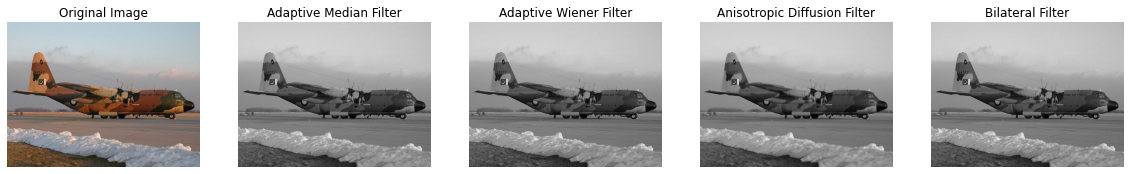

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
from scipy.signal import wiener

# Load the original image
original_image = cv2.imread('c130.jpg')
# Convert the original image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Median Filter
def adaptive_median_filter(image, max_size=7):
    def median_filter_at_point(img, x, y, size):
        k = size // 2
        neighborhood = img[max(0, x-k):x+k+1, max(0, y-k):y+k+1]
        return np.median(neighborhood)

    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            k = 1
            while k <= max_size:
                neighborhood = image[max(0, i-k):i+k+1, max(0, j-k):j+k+1]
                med = np.median(neighborhood)
                z_min = neighborhood.min()
                z_max = neighborhood.max()
                z_med = med
                if z_min < z_med < z_max:
                    z_xy = image[i, j]
                    if z_min < z_xy < z_max:
                        filtered_image[i, j] = z_xy
                    else:
                        filtered_image[i, j] = z_med
                    break
                else:
                    k += 2
            if k > max_size:
                filtered_image[i, j] = image[i, j]
    return filtered_image

adaptive_median_filtered = adaptive_median_filter(gray_image)

# Apply Adaptive Wiener Filter
def adaptive_wiener_filter(image, sizes=[3, 5, 7]):
    local_mean = []
    local_var = []
    noise = estimate_sigma(image, multichannel=False, average_sigmas=True)
    
    # Estimate local mean and variance
    for size in sizes:
        local_mean.append(cv2.blur(image, (size, size)))
        local_var.append(cv2.blur(image**2, (size, size)) - np.square(local_mean[-1]))
    
    # Estimate overall local mean and variance
    local_mean = np.stack(local_mean, axis=2)
    local_var = np.stack(local_var, axis=2)
    overall_local_mean = np.mean(local_mean, axis=2)
    overall_local_var = np.mean(local_var, axis=2)
    
    # Apply Wiener filter
    wiener_filtered = (image - overall_local_mean) * np.divide(overall_local_var, overall_local_var + noise**2)
    wiener_filtered += overall_local_mean
    wiener_filtered = np.clip(wiener_filtered, 0, 255).astype(np.uint8)
    
    return wiener_filtered

adaptive_wiener_filtered = adaptive_wiener_filter(gray_image)

# Apply Anisotropic Diffusion Filter (Perona-Malik Filter)
def anisotropic_diffusion_filter(image, iterations=15, kappa=50, gamma=0.1):
    def diff_coefficient(gradient, kappa):
        return np.exp(-(gradient/kappa)**2)

    img_filtered = image.astype('float32')
    for i in range(iterations):
        # Calculate gradients
        grad_north = np.roll(img_filtered, -1, axis=0) - img_filtered
        grad_south = np.roll(img_filtered, 1, axis=0) - img_filtered
        grad_east = np.roll(img_filtered, -1, axis=1) - img_filtered
        grad_west = np.roll(img_filtered, 1, axis=1) - img_filtered

        # Calculate diffusion coefficients
        c_north = diff_coefficient(grad_north, kappa)
        c_south = diff_coefficient(grad_south, kappa)
        c_east = diff_coefficient(grad_east, kappa)
        c_west = diff_coefficient(grad_west, kappa)

        # Update image
        img_filtered += gamma * (c_north * grad_north + c_south * grad_south + c_east * grad_east + c_west * grad_west)
    
    img_filtered = np.clip(img_filtered, 0, 255).astype('uint8')
    return img_filtered

anisotropic_diffusion_filtered = anisotropic_diffusion_filter(gray_image)

# Apply Bilateral Filter
bilateral_filtered = denoise_bilateral(gray_image, sigma_color=0.05, sigma_spatial=15, multichannel=False)

# Display the images
plt.figure(figsize=(20, 10))

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Adaptive Median Filter
plt.subplot(1, 5, 2)
plt.imshow(adaptive_median_filtered, cmap='gray')
plt.title('Adaptive Median Filter')
plt.axis('off')

# Adaptive Wiener Filter
plt.subplot(1, 5, 3)
plt.imshow(adaptive_wiener_filtered, cmap='gray')
plt.title('Adaptive Wiener Filter')
plt.axis('off')

# Anisotropic Diffusion Filter
plt.subplot(1, 5, 4)
plt.imshow(anisotropic_diffusion_filtered, cmap='gray')
plt.title('Anisotropic Diffusion Filter')
plt.axis('off')

# Bilateral Filter
plt.subplot(1, 5, 5)
plt.imshow(bilateral_filtered, cmap='gray')
plt.title('Bilateral Filter')
plt.axis('off')

# Show the images
plt.show()


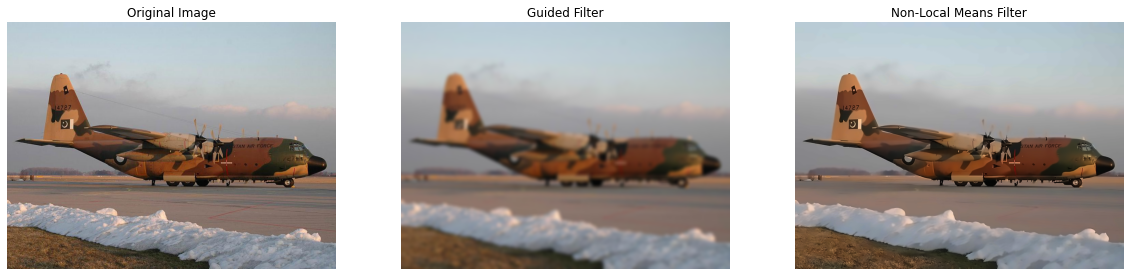

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Load the image
image_path = 'c130.jpg'
original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Guided filter
def apply_guided_filter(image, radius, epsilon):
    # Convert to float32
    image_float = np.float32(image) / 255.0
    # Apply the guided filter
    filtered_image = cv2.ximgproc.guidedFilter(
        guide=image_float,
        src=image_float,
        radius=radius,
        eps=epsilon,
        dDepth=-1
    )
    # Convert back to uint8
    filtered_image = (filtered_image * 255).astype(np.uint8)
    return filtered_image

# Non-local means filter
def apply_non_local_means_filter(image, h=10, hForColorComponents=10):
    return cv2.fastNlMeansDenoisingColored(image, None, h, hForColorComponents, 7, 21)


# Apply filters
gf_image = apply_guided_filter(original_image_rgb, radius=5, epsilon=1e-6)
nlm_image = apply_non_local_means_filter(original_image_rgb)

# Display images
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

display_images([original_image_rgb, gf_image, nlm_image],
               ['Original Image', 'Guided Filter', 'Non-Local Means Filter'])



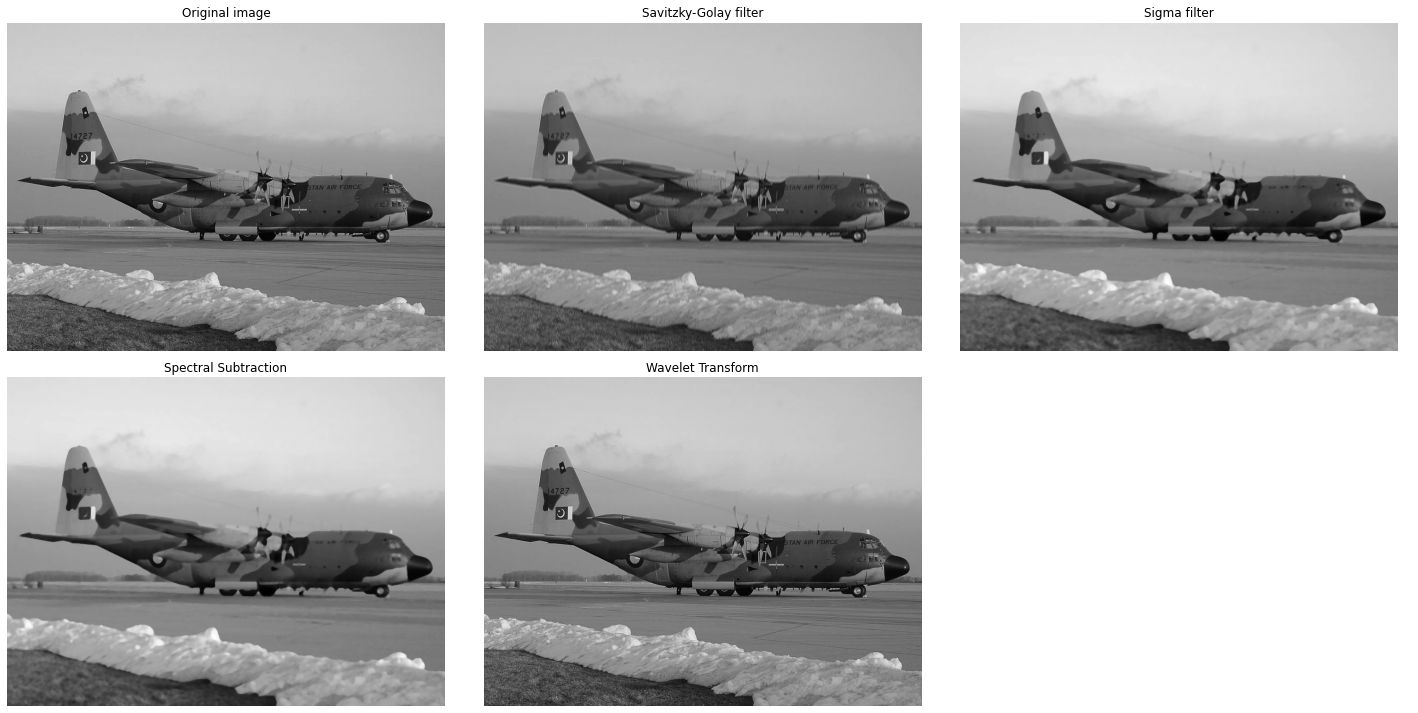

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from skimage.restoration import denoise_wavelet, estimate_sigma
from scipy.ndimage import median_filter

# Load the original image
image = cv2.imread('c130.jpg', cv2.IMREAD_GRAYSCALE)

# Savitzky-Golay Filter
# Here we apply the Savitzky-Golay filter to the image.
# The window size is 11 and the polynomial order is 3.
savgol_filtered = savgol_filter(image, window_length=11, polyorder=3, axis=0)

# Sigma Filter
# We create a sigma filter by applying a median filter to the image.
# A 7x7 kernel is used here.
sigma_filtered = median_filter(image, size=7)

# Spectral Subtraction
# For spectral subtraction, we first calculate the noise estimate by subtracting
# the smoothed image from the original image and then subtract this noise estimate
# from the original image.
smoothed_image = median_filter(image, size=7)
noise_estimate = image - smoothed_image
spectral_subtracted = np.clip(image - noise_estimate, 0, 255)

# Wavelet Transform for Denoising
# The wavelet transform is applied using the 'denoise_wavelet' function from the skimage library.
# We use the default 'BayesShrink' which automatically computes a thresholding value.
# The 'estimate_sigma' function estimates the noise standard deviation from the image.
sigma_est = estimate_sigma(image, multichannel=False, average_sigmas=True)
wavelet_denoised = denoise_wavelet(image, multichannel=False, method='BayesShrink', mode='soft',
                                   sigma=sigma_est, wavelet_levels=3)

# Converting the floating point image in the range [0,1] to uint8
wavelet_denoised = (wavelet_denoised * 255).astype(np.uint8)

# Display the results
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax = axes.ravel()

# Original image
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[0].axis('off')

# Savitzky-Golay filter result
ax[1].imshow(savgol_filtered, cmap=plt.cm.gray)
ax[1].set_title('Savitzky-Golay filter')
ax[1].axis('off')

# Sigma filter result
ax[2].imshow(sigma_filtered, cmap=plt.cm.gray)
ax[2].set_title('Sigma filter')
ax[2].axis('off')

# Spectral Subtraction result
ax[3].imshow(spectral_subtracted, cmap=plt.cm.gray)
ax[3].set_title('Spectral Subtraction')
ax[3].axis('off')

# Wavelet denoised image
ax[4].imshow(wavelet_denoised, cmap=plt.cm.gray)
ax[4].set_title('Wavelet Transform')
ax[4].axis('off')

# Hide the 6th plot (extra subplot)
ax[5].axis('off')

plt.tight_layout()
plt.show()


In [4]:
def spectral_subtraction(image, noise_level):
    # Perform a Fast Fourier Transform
    f_transform = np.fft.fft2(image)
    # Shift the zero frequency component to the center
    f_shift = np.fft.fftshift(f_transform)
    # Subtract the (estimated) noise spectrum
    f_shift -= noise_level
    # Shift back
    f_ishift = np.fft.ifftshift(f_shift)
    # Inverse FFT to get the image back
    img_back = np.fft.ifft2(f_ishift)
    # Take the absolute value to get the magnitude
    img_back = np.abs(img_back)
    return img_back


In [5]:
def wavelet_denoise(image, threshold):
    # Apply a high-pass filter (simplified wavelet high-frequency component)
    high_pass = image - cv2.GaussianBlur(image, (3, 3), 0)
    # Threshold the high frequency image (wavelet coefficient thresholding)
    high_pass[np.abs(high_pass) < threshold] = 0
    # Add the high frequency image back to the original (simplified wavelet reconstruction)
    denoised_image = image + high_pass
    return denoised_image


In [7]:
def apply_filters(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Savitzky-Golay filter (window size 5, polynomial order 1)
    sg_filtered = savitzky_golay(image, 5, 1)

    # Apply Sigma filter (window size 3, sigma 1)
    sigma_filtered = sigma_filter(image, 3, 1)

    # Apply Spectral Subtraction (assuming noise level 10)
    spectral_subtracted = spectral_subtraction(image, 10)

   


In [8]:
apply_filters('c130.jpg')

NameError: name 'savitzky_golay' is not defined

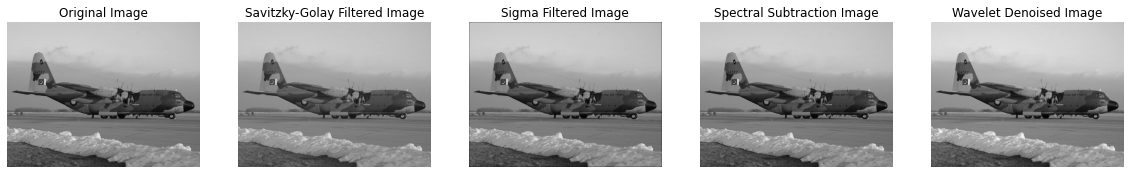

In [10]:
# First, let's define the complete code for the four filters.
# Import necessary libraries
import numpy as np
import cv2
from scipy.signal import convolve2d

# Define the Savitzky-Golay filter function
def savitzky_golay(image, window_size, order):
    # Generate Savitzky-Golay kernel
    half_window = (window_size - 1) // 2
    b = np.mat([[k**i for i in range(order + 1)] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[0]
    
    # Apply the kernel to the image
    sg_filtered = convolve2d(image, np.reshape(m, (1, -1)), boundary='symm', mode='same')
    return sg_filtered

# Define the Sigma filter function
def sigma_filter(image, size, sigma):
    result = np.zeros_like(image)
    half_size = size // 2
    for i in range(half_size, image.shape[0] - half_size):
        for j in range(half_size, image.shape[1] - half_size):
            # Define the local neighborhood
            local = image[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
            # Calculate local mean and standard deviation
            local_mean = np.mean(local)
            local_std = np.std(local)
            # If the pixel is within sigma standard deviations of the mean, keep it, otherwise replace it
            if abs(image[i, j] - local_mean) > sigma * local_std:
                result[i, j] = local_mean
            else:
                result[i, j] = image[i, j]
    return result

# Define the Spectral Subtraction function
def spectral_subtraction(image, noise_level):
    # Perform Fourier transform
    f_transform = np.fft.fft2(image)
    # Shift the zero frequency component to the center
    f_shift = np.fft.fftshift(f_transform)
    # Subtract the (estimated) noise spectrum
    f_shift = f_shift - noise_level
    # Inverse shift and inverse Fourier transform
    f_ishift = np.fft.ifftshift(f_shift)
    img_back = np.fft.ifft2(f_ishift)
    # Take the magnitude
    img_back = np.abs(img_back)
    return img_back

# Define a simple wavelet-like denoising function
def wavelet_denoise(image, threshold):
    # Apply a Gaussian blur (low-pass filter)
    low_pass = cv2.GaussianBlur(image, (3, 3), 0)
    # Subtract low-pass from the original to get a high-pass filter effect
    high_pass = image - low_pass
    # Threshold the high-pass filter to remove small coefficients (noise)
    high_pass[np.abs(high_pass) < threshold] = 0
    # Reconstruct the denoised image
    denoised_image = image - high_pass
    return denoised_image

# Now let's read the image and apply these filters
# Read the image in grayscale
image = cv2.imread('c130.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Savitzky-Golay filter
sg_filtered = savitzky_golay(image, window_size=5, order=2)

# Apply Sigma filter
sigma_filtered = sigma_filter(image, size=3, sigma=1)

# Apply Spectral Subtraction
spectral_subtracted = spectral_subtraction(image, noise_level=10)

# Apply Wavelet-like denoising
wavelet_denoised = wavelet_denoise(image, threshold=10)

# Now, let's display all the images.
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Savitzky-Golay filtered image
plt.subplot(1, 5, 2)
plt.imshow(sg_filtered, cmap='gray')
plt.title('Savitzky-Golay Filtered Image')
plt.axis('off')

# Sigma filtered image
plt.subplot(1, 5, 3)
plt.imshow(sigma_filtered, cmap='gray')
plt.title('Sigma Filtered Image')
plt.axis('off')

# Spectral Subtraction image
plt.subplot(1, 5, 4)
plt.imshow(spectral_subtracted, cmap='gray')
plt.title('Spectral Subtraction Image')
plt.axis('off')

# Wavelet Denoised image
plt.subplot(1, 5, 5)
plt.imshow(wavelet_denoised, cmap='gray')
plt.title('Wavelet Denoised Image')
plt.axis('off')

plt.show()
